In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
device = torch.device("cpu")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

In [ ]:
def set_seed(seed=42, deterministic=True):
    """
    设置所有可能的随机种子，确保 PyTorch 实验可重复性
    参数:
        seed (int): 随机种子值
        deterministic (bool): 是否使用确定性算法
    """
    # Python 内置随机模块
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    # CUDA 操作的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果使用多 GPU
    # 设置 CUDA 后端的确定性选项
    if deterministic:
        # 使用确定性算法
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # 设置环境变量
        os.environ['PYTHONHASHSEED'] = str(seed)
        # PyTorch 2.0+ 的额外设置
        if hasattr(torch, 'use_deterministic_algorithms'):
            torch.use_deterministic_algorithms(True)
        elif hasattr(torch, 'set_deterministic'):
            torch.set_deterministic(True)
    
    print(f"随机种子已设置为: {seed}")
    if deterministic:
        print("已启用确定性模式")


In [97]:
def load_data(file_path):
    # 获取所有sheet的名称
    sheet_names = pd.ExcelFile(file_path).sheet_names

    # 读取所有sheet并存储在一个字典中
    data_frames = {}
    for sheet in sheet_names:
        data_frames[sheet] = pd.read_excel(file_path, sheet_name=sheet)


    for sheet, df in data_frames.items():
        # 行列互换（转置）
        df = df.transpose()

        # 将转置后的DataFrame的第一行设为列名
        df.columns = df.iloc[0]
        df = df[1:]

        df.reset_index(inplace=True, drop=False)
        df.rename(columns={'index': '发酵周期/h'}, inplace=True)
        df.columns.name = sheet

        # 转换为数值类型，如果不能转换则设置为NaN
        df = df.apply(pd.to_numeric, errors='coerce')

        # 插值
        # df = df.interpolate(method='quadratic')
        columns_to_interpolate = ['酶活', '菌浓ml/50ml', '菌浓g/50ml', '碱重kg', '重量KG']
        df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear')

        # # 删除缺失值
        # columns =  [col for col in df.columns]
        # df = df[columns].dropna()

        # 更新字典中的 DataFrame
        if len(df.index) != 0:
            data_frames[sheet] = df
        else:
            data_frames[sheet] = None

    data_frames = {sheet: df for sheet, df in data_frames.items() if df is not None}

    df_train = []
    for sheet, df in data_frames.items():
        if len(df.columns[df.isnull().any()].tolist()) == 0:
            df_train.append(df)

    X_df, Y_df = address_data(df_train)

    return X_df, Y_df


def address_data(data_train):
    X1 = []
    Y1 = []

    for data in data_train:
        # 为每个属性添加滞后特征
        for column in data.columns:
            # if column != '发酵周期/h':
            data[f'{column}_lag_1'] = data[column].shift(1)

        exog_columns = ['发酵周期/h'] + [col for col in data.columns if 'lag' in col]
        exog_data = data[exog_columns].dropna()
        
        # 5. 定义因变量
        endog_data = data.loc[exog_data.index, ['酸钠', '残糖g/dl']]

        X1.append(exog_data)
        Y1.append(endog_data)

    return X1, Y1

    

In [98]:
# 准备数据
X_list, Y_list = load_data('bio_train_new.xlsx')
X_test_list, Y_test_list = load_data('bio_test.xlsx')

# 归一化数据
scaler_X = MinMaxScaler()
scaler_Y1 = MinMaxScaler()
scaler_Y2 = MinMaxScaler()

# 对训练集X进行归一化
X_ls = []
for X in X_list:
    X_values = np.append(np.array(X['发酵周期/h'], dtype=np.float32).reshape(-1, 1)/100,
                         np.array(scaler_X.fit_transform(X.drop(columns=['发酵周期/h'])), dtype=np.float32), axis=1)
    X_ls.append(torch.tensor(X_values, dtype=torch.float32))

# 填充序列，使它们具有相同的长度
X_padded_sequences = pad_sequence(X_ls, batch_first=True, padding_value=-1)
lengths_train = torch.tensor([len(x) for x in X_ls])

# 对训练集Y进行归一化
Y_values1 = np.concatenate([Y.iloc[:, 0].values.flatten().reshape(-1, 1) for Y in Y_list], axis=0)
Y_values2 = np.concatenate([Y.iloc[:, 1].values.flatten().reshape(-1, 1) for Y in Y_list], axis=0)
scaler_Y1.fit(Y_values1)
scaler_Y2.fit(Y_values2)

y_ls = [torch.tensor(np.hstack([scaler_Y1.transform(Y.iloc[:, 0].values.flatten().reshape(-1, 1)),
                                scaler_Y2.transform(Y.iloc[:, 1].values.flatten().reshape(-1, 1))]), dtype=torch.float32) for Y in Y_list]
y_padded_sequences = pad_sequence(y_ls, batch_first=True, padding_value=-1)
y_train = y_padded_sequences

# 对测试集X进行归一化
X_test_ls = []
for X in X_test_list:
    X_values = np.append(np.array(X['发酵周期/h'], dtype=np.float32).reshape(-1, 1)/100,
                         np.array(scaler_X.transform(X.drop(columns=['发酵周期/h'])), dtype=np.float32), axis=1)
    X_test_ls.append(torch.tensor(X_values, dtype=torch.float32))

X_test_padded_sequences = pad_sequence(X_test_ls, batch_first=True, padding_value=-1)
lengths_test = torch.tensor([len(x) for x in X_test_ls])

# 对测试集Y进行归一化
y_test_ls = [torch.tensor(np.hstack([scaler_Y1.transform(Y.iloc[:, 0].values.flatten().reshape(-1, 1)),
                                     scaler_Y2.transform(Y.iloc[:, 1].values.flatten().reshape(-1, 1))]), dtype=torch.float32) for Y in Y_test_list]
y_test_padded_sequences = pad_sequence(y_test_ls, batch_first=True, padding_value=-1)
y_test = y_test_padded_sequences

# 创建数据加载器
train_dataset = TensorDataset(X_padded_sequences, lengths_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = TensorDataset(X_test_padded_sequences, lengths_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # 假设我们有两个输出值

    def forward(self, x, lengths):
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (h_n, c_n) = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True, total_length=x.size(1))  # 使用total_length参数
        # 对每个时间步进行预测
        out = self.fc(output)
        return out

input_size = X_padded_sequences.shape[2]
hidden_size = 256
num_layers = 3
output_size = 2  # 设置输出大小为2
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)

# 定义学习率调度器
scheduler = StepLR(optimizer, step_size=50, gamma=0.9)  # 每100个epoch学习率衰减为原来的0.9倍


In [99]:
# 训练模型
num_epochs = 10
best_loss = 99999
best_eval_loss = 99999
set_seed(18)

for epoch in range(num_epochs):
    model.train()
    loss_epoch = 0
    for inputs, lengths, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        lengths = lengths.cpu().to(torch.int64)  # 确保 lengths 在 CPU 上并且是 int64 类型
        outputs = model(inputs, lengths)

        # 计算所有时间步的损失，忽略填充部分的损失
        mask = (inputs[:, :, 0] != -1).float().unsqueeze(-1).to(device)

        loss = (criterion(outputs, targets) * mask).sum() / mask.sum()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        loss_epoch += loss.item()
    if optimizer.state_dict()['param_groups'][0]['lr'] > 2e-5:
        scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_epoch/len(train_loader):.4f}')
    print("lr:", optimizer.state_dict()['param_groups'][0]['lr'])
    if loss_epoch < best_loss:
        best_loss = loss_epoch/len(train_loader)

    # 保存最佳模型
    if epoch == 0 or loss_epoch < best_loss:
        torch.save(model.state_dict(), 'model.pt')

# # 评估模型并绘制结果
# def plot_results(true_values, predicted_values, attribute_name):
#     if attribute_name == '残糖':
#         attribute_name = 'Residual Sugar'
#     else:
#         attribute_name = 'Sodium Acid'
#     plt.figure(figsize=(12, 6))
#     plt.plot(true_values, 'o', label=f'Target values {attribute_name}', linestyle='-', markersize=5)
#     plt.plot(predicted_values, 'x', label=f'Predicted values {attribute_name}', linestyle='--', markersize=5)
#     plt.xlabel('Sample Index')
#     plt.ylabel(attribute_name)
#     plt.legend()
#     plt.title(f'Contrast between Target and Prediction: {attribute_name}')
#     plt.savefig(f'pic_{attribute_name}.png')

随机种子已设置为: 18
已启用确定性模式
Epoch [1/10], Loss: 0.1481
lr: 0.004
Epoch [2/10], Loss: 0.0624
lr: 0.004
Epoch [3/10], Loss: 0.0543
lr: 0.004
Epoch [4/10], Loss: 0.0356
lr: 0.004
Epoch [5/10], Loss: 0.0287
lr: 0.004
Epoch [6/10], Loss: 0.0230
lr: 0.004
Epoch [7/10], Loss: 0.0231
lr: 0.004
Epoch [8/10], Loss: 0.0221
lr: 0.004
Epoch [9/10], Loss: 0.0183
lr: 0.004
Epoch [10/10], Loss: 0.0128
lr: 0.004


In [100]:
# 加载并且评估
model_state_dict = torch.load('model.pt', map_location=device)
model.load_state_dict(model_state_dict)
model.eval()

with torch.no_grad():
    loss_eval = 0
    all_preds = []
    all_targets = []
    
    for inputs, lengths, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        lengths = lengths.cpu().to(torch.int64)  # 确保 lengths 在 CPU 上并且是 int64 类型
        outputs = model(inputs, lengths)

        # 计算所有时间步的损失，忽略填充部分的损失
        mask = (inputs[:, :, 0] != -1).float().unsqueeze(-1).to(device)

        loss = (criterion(outputs, targets) * mask).sum() / mask.sum()
        loss_eval += loss.item()

        all_preds.append(outputs.cpu())
        all_targets.append(targets.cpu())

    avg_eval_loss = loss_eval / len(test_loader)
    print(f'Eval Loss: {avg_eval_loss:.4f}')

    # 将预测值和真实值从填充值中提取出来
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    preds_inverse = np.zeros_like(all_preds)
    targets_inverse = np.zeros_like(all_targets)
    for i in range(all_preds.shape[0]):
        for j in range(all_preds.shape[1]):
            preds_inverse[i, j, 0] = scaler_Y1.inverse_transform(all_preds[i, j, 0].reshape(-1, 1)).squeeze()
            preds_inverse[i, j, 1] = scaler_Y2.inverse_transform(all_preds[i, j, 1].reshape(-1, 1)).squeeze()
            targets_inverse[i, j, 0] = scaler_Y1.inverse_transform(all_targets[i, j, 0].reshape(-1, 1)).squeeze()
            targets_inverse[i, j, 1] = scaler_Y2.inverse_transform(all_targets[i, j, 1].reshape(-1, 1)).squeeze()

    # 去除填充部分
    valid_mask = all_targets[:, :, 0] > 0
    # for i in range(2):  # 对于两个输出值
    #     true_values = targets_inverse[:, :, i][valid_mask]
    #     predicted_values = preds_inverse[:, :, i][valid_mask]
    #     attribute_name = Y_list[0].columns[i]
    #     plot_results(true_values, predicted_values, attribute_name[:2])

Eval Loss: 0.0454


In [101]:
def plot_results(true_values, predicted_values, attribute_name, style='modern'):
    """
    绘制真实值和预测值的对比图并保存
    true_values: 真实值数组
    predicted_values: 预测值数组
    attribute_name: 属性名称
    style: 可选风格 'modern', 'minimal', 'scientific', 'dark'
    """
    # 属性名称映射
    attribute_map = {
        '残糖': 'Residual Sugar',
        '酸度': 'Acidity',
        '酒精度': 'Alcohol Content',
        '密度': 'Density',
        '挥发性酸': 'Volatile Acidity'
    }
    
    # 获取英文属性名，如果没有映射则保持原样
    display_name = attribute_map.get(attribute_name, attribute_name)
    
    # 设置绘图风格
    if style == 'modern':
        plt.style.use('seaborn-v0_8-whitegrid')
        colors = ('#3498db', '#e74c3c')  # 蓝色和红色
        alpha = 0.8
        bg_color = '#f9f9f9'
    elif style == 'minimal':
        plt.style.use('seaborn-v0_8-white')
        colors = ('#2c3e50', '#e67e22')  # 深蓝和橙色
        alpha = 0.9
        bg_color = 'white'
    elif style == 'scientific':
        plt.style.use('ggplot')
        colors = ('#2980b9', '#c0392b')  # 蓝色和深红色
        alpha = 0.7
        bg_color = '#f5f5f5'
    elif style == 'dark':
        plt.style.use('dark_background')
        colors = ('#3498db', '#e74c3c')  # 亮蓝和亮红
        alpha = 0.8
        bg_color = '#2c3e50'
    else:
        plt.style.use('default')
        colors = ('blue', 'red')
        alpha = 0.7
        bg_color = 'white'
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
    fig.patch.set_facecolor(bg_color)
    
    # 计算误差统计
    errors = np.array(true_values) - np.array(predicted_values)
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    r2 = r2_score(true_values,predicted_values)
    
    # 绘制真实值和预测值
    x = np.arange(len(true_values))
    ax.plot(x, true_values, 'o-', label=f'Target values', color=colors[0], 
            alpha=alpha, markersize=6, linewidth=1.5)
    ax.plot(x, predicted_values, 'x--', label=f'Predicted values', color=colors[1], 
            alpha=alpha, markersize=6, linewidth=1.5)
    
    # 添加误差区域
    ax.fill_between(x, true_values, predicted_values, color=colors[1], alpha=0.15)
    
    # 设置坐标轴和网格
    ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax.set_ylabel(display_name, fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 设置刻度字体
    ax.tick_params(axis='both', labelsize=10)
    
    # 添加标题和子标题
    ax.set_title(f'Comparison of Target vs Prediction: {display_name}', 
                fontsize=14, fontweight='bold', pad=20)
    ax.text(0.5, -0.15, f'MAE: {mae:.4f} | RMSE: {rmse:.4f}| R2:{r2:.4f}', 
            horizontalalignment='center', fontsize=11, transform=ax.transAxes)
    
    # 美化图例
    legend = ax.legend(loc='best', frameon=True, fontsize=10)
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('lightgray')
    
    # 添加水印
    fig.text(0.99, 0.01, 'Created with Python', fontsize=8, 
             color='gray', ha='right', va='bottom', alpha=0.5)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存高质量图片
    plt.savefig(f'visualization_{display_name}.png', dpi=300, bbox_inches='tight')
    
    # 返回图形对象，以便进一步自定义
    return fig, ax


/var/folders/6h/xbss61y56wnfzvzcm7k4524h0000gn/T/ipykernel_44021/4019961982.py:92: UserWarning: Glyph 37240 (\N{CJK UNIFIED IDEOGRAPH-9178}) missing from current font.
  plt.tight_layout()
/var/folders/6h/xbss61y56wnfzvzcm7k4524h0000gn/T/ipykernel_44021/4019961982.py:92: UserWarning: Glyph 38048 (\N{CJK UNIFIED IDEOGRAPH-94A0}) missing from current font.
  plt.tight_layout()
/var/folders/6h/xbss61y56wnfzvzcm7k4524h0000gn/T/ipykernel_44021/4019961982.py:95: UserWarning: Glyph 37240 (\N{CJK UNIFIED IDEOGRAPH-9178}) missing from current font.
  plt.savefig(f'visualization_{display_name}.png', dpi=300, bbox_inches='tight')
/var/folders/6h/xbss61y56wnfzvzcm7k4524h0000gn/T/ipykernel_44021/4019961982.py:95: UserWarning: Glyph 38048 (\N{CJK UNIFIED IDEOGRAPH-94A0}) missing from current font.
  plt.savefig(f'visualization_{display_name}.png', dpi=300, bbox_inches='tight')
/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37240 (\N{CJK UNI

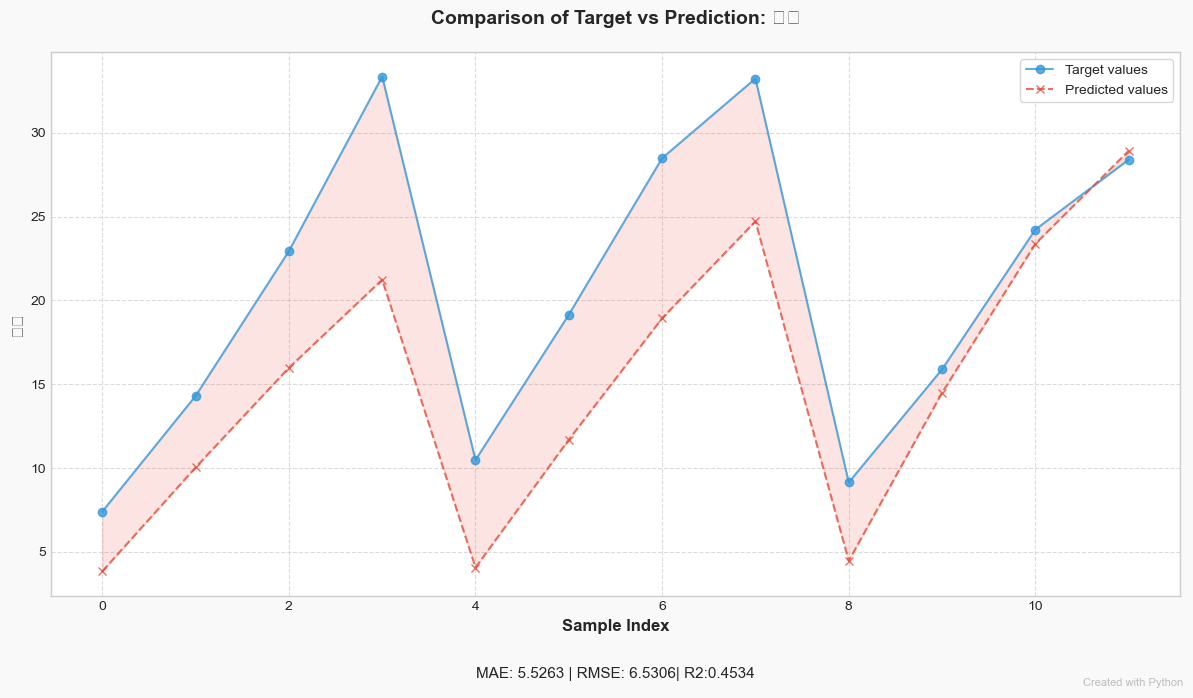

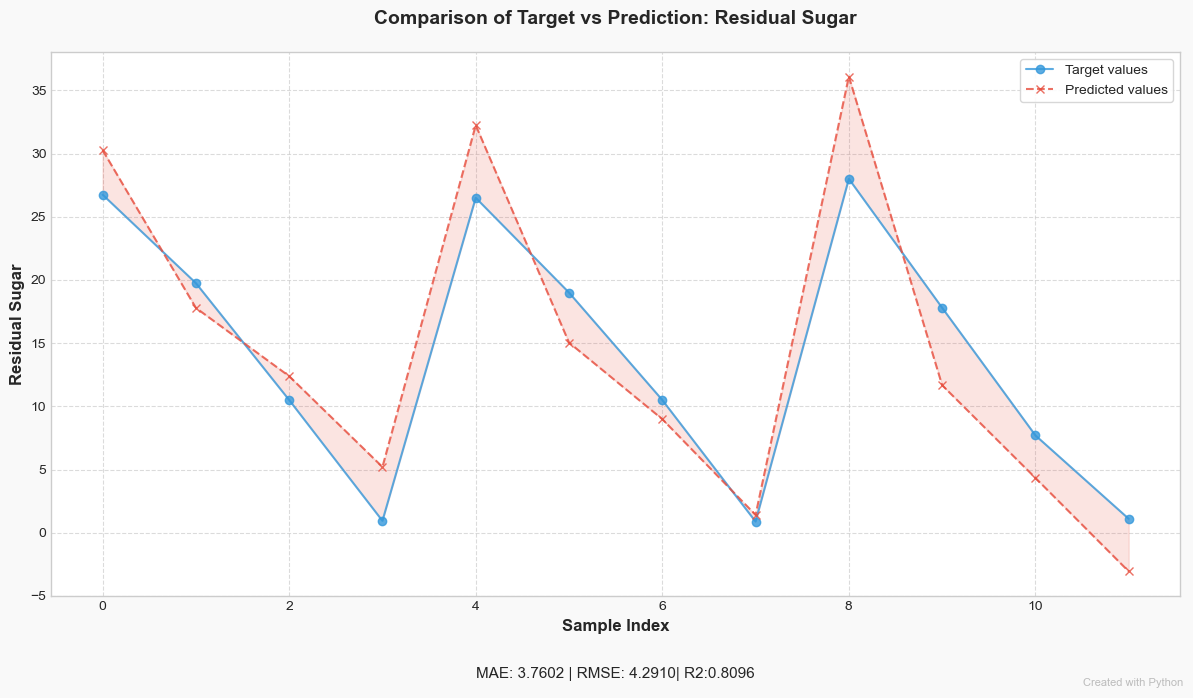

In [102]:

for i in range(2):  # 对于两个输出值
        true_values = targets_inverse[:, :, i][valid_mask]
        predicted_values = preds_inverse[:, :, i][valid_mask]
        attribute_name = Y_list[0].columns[i]
        plot_results(true_values, predicted_values, attribute_name[:2])